# Predicting High-Severity Accidents (Severity=4) with PySpark MLlib

This notebook implements a binary classification pipeline to predict high-severity (Severity=4) car accidents using PySpark MLlib. We address class imbalance, engineer features, train models, evaluate performance, and interpret key predictors for actionable insights.

## Initialize Spark Session and Load Data

This cell sets up the Spark session and loads the US accidents dataset into a Spark DataFrame. It also prints the schema to inspect the data types.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, isnull, udf, col
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.sql.types import StringType
# Load, clean, drop, quartile filter, and discretize in one cell
spark = SparkSession.builder.appName("project").master("local[*]").config("spark.driver.memory",  "28g").config("spark.executor.memory", "28g").getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

# Load dataset
data_path = "/kaggle/input/us-accidents-cleaned"
df = spark.read.csv(data_path, header=True, inferSchema=True).cache()
df.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/28 16:28:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi)_cont: double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Humidity(%)_cont: double (nullable = true)
 |-- Pressure(in)_cont: double (nullable = true)
 |-- Visibility(mi)_cont: double (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph)_cont: double (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- Amenity: boolean (nullable = true)
 |-- Bump: boolean (nullable = tr

## Create Binary Target Column

Adds a new column `is_high_severity` to indicate whether an accident is of the highest severity (Severity=4). This column will be used as the target for classification.

In [3]:
from pyspark.sql.functions import when, col

# Add binary target column: 1 if Severity == 4, else 0
df_bin = df.withColumn("is_high_severity", when(col("Severity") == 4, 1).otherwise(0))

# # Show class distribution
# class_dist = df_bin.groupBy("is_high_severity").count().orderBy("is_high_severity")
# class_dist.show()

# Business meaning: 'is_high_severity' = 1 means the accident had the most severe impact on traffic.

## Drop Redundant Columns

Removes unnecessary or redundant columns from the DataFrame to simplify the feature set for modeling.

In [4]:
# Drop redundant/descritized columns (keep only continuous or only binned, not both)
redundant_cols = [
    "Distance(mi)","Severity", "Weather_Timestamp", "Description", "End_Time", "Distance(mi)_cont",
]
df_model = df_bin.drop(*[c for c in redundant_cols if c in df.columns])
df_model.printSchema()

root
 |-- Start_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Humidity(%)_cont: double (nullable = true)
 |-- Pressure(in)_cont: double (nullable = true)
 |-- Visibility(mi)_cont: double (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph)_cont: double (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- Amenity: boolean (nullable = true)
 |-- Bump: boolean (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Give_Way: boolean (nullable = true)
 |-- Junction: boolean (nullable = true)
 |-- No_Exit: boolean (nullable = true)
 |-- Railway: boolean (nullable = true)
 |-- Roundabout: bool

## Define Resampling Function

Defines a function to balance the dataset by either oversampling the minority class or undersampling the majority class.

In [5]:
from pyspark.sql import DataFrame

def resample(df: DataFrame, label_col: str, n: int, seed: int = 42) -> DataFrame:
    """
    Resample a PySpark DataFrame to have n samples from each class in label_col.
    Minority class is oversampled with replacement, majority class is undersampled without replacement.
    """
    classes = [row[label_col] for row in df.select(label_col).distinct().collect()]
    resampled_dfs = []
    for cls in classes:
        df_cls = df.filter(col(label_col) == cls)
        count_cls = df_cls.count()
        if count_cls >= n:
            # Undersample
            sampled = df_cls.sample(withReplacement=False, fraction=float(n)/count_cls, seed=seed).limit(n)
        else:
            # Oversample
            sampled = df_cls.sample(withReplacement=True, fraction=float(n)/count_cls, seed=seed).limit(n)
        resampled_dfs.append(sampled)
    return resampled_dfs[0].union(resampled_dfs[1])

## Visualizing Class Imbalance

The bar plot above shows the distribution of accident severities after binarizing the target. There is a significant class imbalance: the number of high-severity accidents (Severity=4) is much lower than non-severe accidents (Severity 0-3).  
**Imbalance ratio (majority/minority): 41.7**  
This high imbalance highlights the need for resampling or other techniques to ensure fair model training and evaluation.

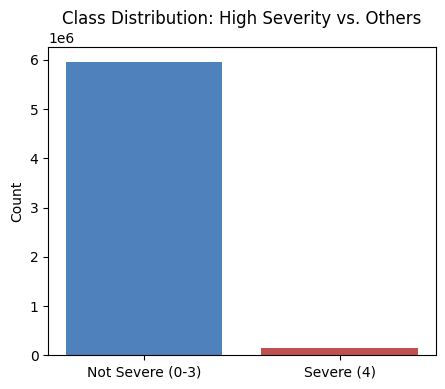

Imbalance ratio (majority/minority): 41.7


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Collect class distribution for plotting
class_dist_pd = class_dist.toPandas()
plt.figure(figsize=(5,4))
plt.bar(class_dist_pd["is_high_severity"], class_dist_pd["count"], color=["#4F81BD", "#C0504D"])
plt.xticks([0,1], ["Not Severe (0-3)", "Severe (4)"])
plt.ylabel("Count")
plt.title("Class Distribution: High Severity vs. Others")
plt.show()

# Calculate imbalance ratio
total = class_dist_pd["count"].sum()
minority = class_dist_pd[class_dist_pd["is_high_severity"]==1]["count"].values[0]
majority = class_dist_pd[class_dist_pd["is_high_severity"]==0]["count"].values[0]
print(f"Imbalance ratio (majority/minority): {majority/minority:.1f}")



## Resample and Plot POI Features with respect to high-severity accidents (Severity=4)

This cell resample the data and plot the distribution of Points of Interest (POI) features by class.

In [7]:
df_bl = resample(df_model, "is_high_severity", 20000)
df_bl.groupBy("is_high_severity").count().show()
POI_features = [
    'Amenity','Bump','Crossing','Give_Way','Junction','No_Exit',
    'Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal'
]
cols_to_plot = POI_features + ['is_high_severity']
df_bl_pd = df_bl.select(*cols_to_plot).toPandas()

+----------------+-----+
|is_high_severity|count|
+----------------+-----+
|               1|19882|
|               0|20000|
+----------------+-----+



/tmp/ipykernel_31/1453687949.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 4, i)
/tmp/ipykernel_31/1453687949.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 4, i)
/tmp/ipykernel_31/1453687949.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 4, i)
/tmp/ipykernel_31/1453687949.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 4, i)
/tmp/ipykernel_31/1453687949.py:8: MatplotlibDeprecationWarning: Auto-removal of

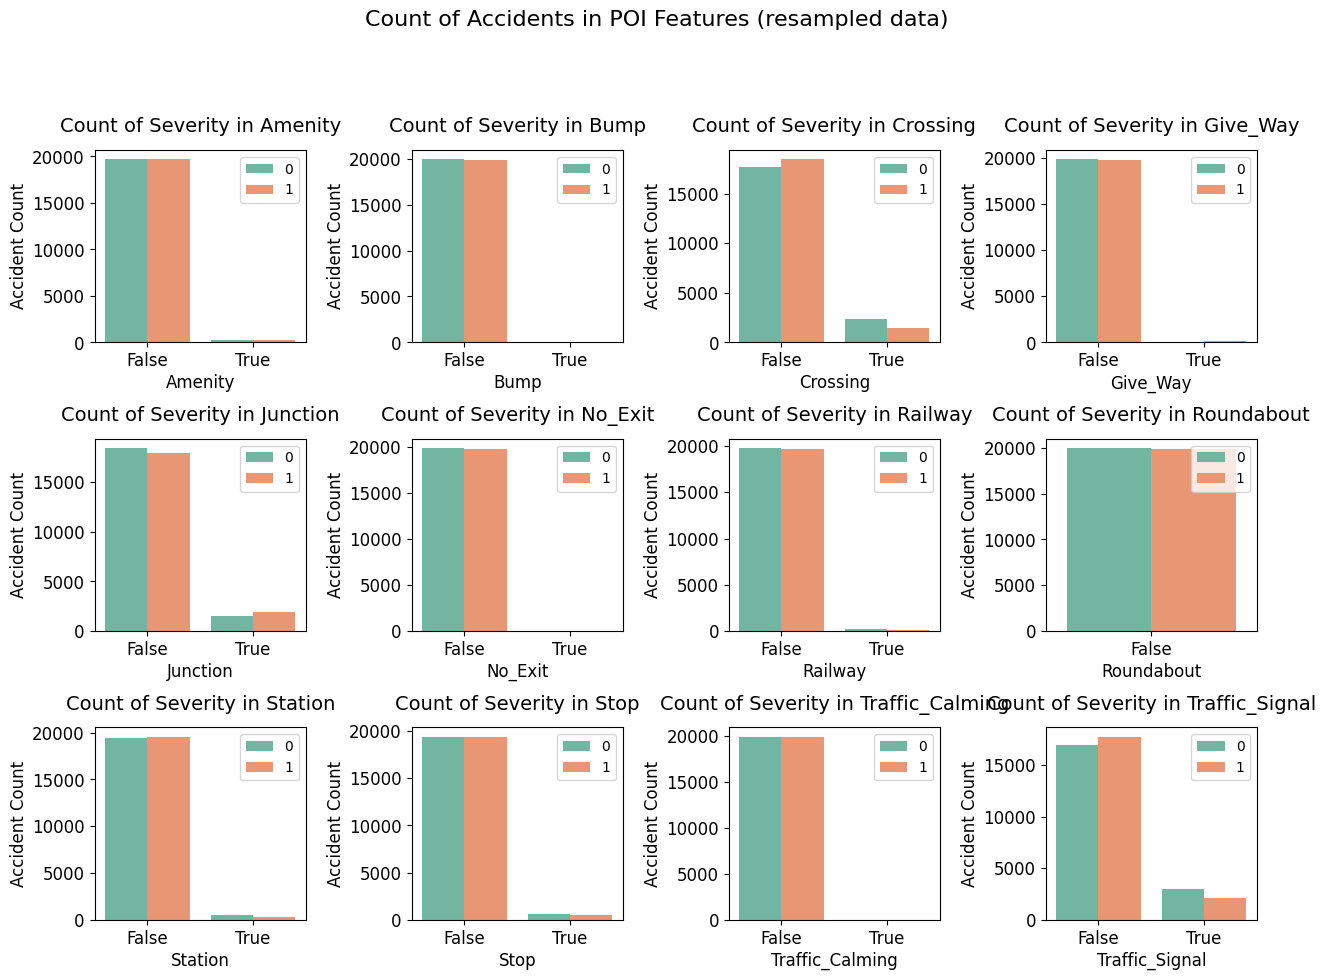

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i, feature in enumerate(POI_features, 1):    
    plt.subplot(3, 4, i)
    sns.countplot(x=feature, hue='is_high_severity', data=df_bl_pd, palette="Set2")
    plt.xlabel(f'{feature}', size=12, labelpad=3)
    plt.ylabel('Accident Count', size=12, labelpad=3)    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    plt.legend(['0', '1'], loc='upper right', prop={'size': 10})
    plt.title(f'Count of Severity in {feature}', size=14, y=1.05)

fig.suptitle('Count of Accidents in POI Features (resampled data)', y=1.02, fontsize=16)
plt.show()

The plot indicates that accidents near traffic signals and crossings are much less likely to be severe, while accidents near junctions are slightly more likely to be severe. This may be because drivers tend to slow down at crossings and traffic signals, reducing accident severity, whereas higher speeds at junctions can lead to more severe outcomes. Most other POI features are highly imbalanced, making it difficult to draw clear conclusions about their relationship with severity.

Based on this analysis, the following features will be dropped due to their lack of predictive value or imbalance:

- 'Bump'
- 'Give_Way'
- 'No_Exit'
- 'Roundabout'
- 'Traffic_Calming'

In [39]:
df_model = df_model.drop(*['Amenity','Bump','Give_Way','No_Exit','Roundabout','Traffic_Calming'])
df_model.printSchema()
print(len(df_model.columns))

root
 |-- Start_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Humidity(%)_cont: double (nullable = true)
 |-- Pressure(in)_cont: double (nullable = true)
 |-- Visibility(mi)_cont: double (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph)_cont: double (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Junction: boolean (nullable = true)
 |-- Railway: boolean (nullable = true)
 |-- Station: boolean (nullable = true)
 |-- Stop: boolean (nullable = true)
 |-- Traffic_Signal: boolean (nullable = true)
 |-- Sunrise_Sunset: string (nullable = true)
 |-- Temp

## Downsample Majority Class

Performs downsampling to reduce the number of majority class samples.

In [40]:
from pyspark.sql.functions import col

# Group by label and count
class_dist = df_model.groupBy("is_high_severity").count().orderBy("is_high_severity")
class_dist.show()

# Collect counts into Python
class_counts = class_dist.collect()
minority = next(row['count'] for row in class_counts if row['is_high_severity'] == 1)
majority = next(row['count'] for row in class_counts if row['is_high_severity'] == 0)

# Undersampling
sample_ratio = 3  # Keep 3x more majority than minority
fraction = (sample_ratio * minority) / majority

sampled_majority = df_model.filter(col("is_high_severity") == 0).sample(withReplacement=False, fraction=fraction, seed=42)
sampled_minority = df_model.filter(col("is_high_severity") == 1)
df_downsampled = sampled_majority.union(sampled_minority)

# Show new class distribution
df_downsampled.groupBy("is_high_severity").count().orderBy("is_high_severity").show()


+----------------+-------+
|is_high_severity|  count|
+----------------+-------+
|               0|5996705|
|               1| 143484|
+----------------+-------+



+----------------+------+
|is_high_severity| count|
+----------------+------+
|               0|430828|
|               1|143484|
+----------------+------+



## Upsample Minority Class

Performs upsampling of the minority class by duplicating and adding noise to samples, then balances the dataset.

In [41]:
from pyspark.sql.functions import col, rand

# Split into minority and majority
minority_df = df_model.filter(col("is_high_severity") == 1)
majority_df = df_model.filter(col("is_high_severity") == 0)

# Function to add slight noise
def add_noise(df, noise_level=0.01):
    for colname in ["Humidity(%)_cont", "Pressure(in)_cont", "Visibility(mi)_cont", 
                    "Wind_Speed(mph)_cont", "Temperature(C)_cont", "Start_Lat", "Start_Lng"]:
        df = df.withColumn(colname, col(colname) + rand() * noise_level)
    return df

# Upsample minority
upsample_factor = 5  # how many times to duplicate minority
upsampled_minority = minority_df
for _ in range(upsample_factor - 1):
    noisy = add_noise(minority_df)
    upsampled_minority = upsampled_minority.union(noisy)

# Now control total size and balance

# Count how many records now
minority_count = upsampled_minority.count()
print(f"Minority after upsampling: {minority_count}")

# Decide how much majority you want
# Example: target ratio majority:minority = 1:1
target_ratio = 1  # 1 means same number as minority

desired_majority_count = int(minority_count * target_ratio)

# Sample the majority
majority_fraction = desired_majority_count / majority_df.count()
print(f"Majority sampling fraction: {majority_fraction}")

sampled_majority = majority_df.sample(withReplacement=False, fraction=majority_fraction, seed=42)

# Union together
df_balanced = upsampled_minority.union(sampled_majority)

# Check final class distribution
df_balanced.groupBy("is_high_severity").count().orderBy("is_high_severity").show()


Minority after upsampling: 717420
Majority sampling fraction: 0.11963569993854958


+----------------+------+
|is_high_severity| count|
+----------------+------+
|               0|718529|
|               1|717420|
+----------------+------+



##  Feature Engineering (Indexing and Assembling)

Defines a function to index categorical features, cast boolean columns, and assemble all features into a single vector for modeling.

In [42]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.functions import col


def index(df_balanced, cont=True):
    # 1. Categorical columns to index (adding all the new string columns you want)
    categorical_cols=[]
    bool_cols=[]
    categorical_cols=[]
    if(cont):
        categorical_cols = [
             "State",    "Wind_Direction", "Weather_Condition", 
            "Sunrise_Sunset", "Urban_Rural"
        ]
        
        # 2. Boolean columns (will be casted to int)
        bool_cols = ["Crossing", "Junction", "Railway", "Station", "Stop", "Traffic_Signal"]
        
        # 3. Numerical continuous columns
        numerical_cols = [
            "Start_Lat", "Start_Lng", 
            "Humidity(%)_cont", "Pressure(in)_cont",
            "Visibility(mi)_cont", "Wind_Speed(mph)_cont", 
            "Temperature(C)_cont"
        ]

    else: 
        categorical_cols = [
             "State",    "Wind_Direction", "Weather_Condition", 
            "Sunrise_Sunset", "Urban_Rural", "Humidity(%)", "Pressure(in)",
            "Visibility(mi)", "Wind_Speed(mph)", 
            "Temperature(C)"
        ]
        
        # 2. Boolean columns (will be casted to int)
        bool_cols = ["Crossing", "Junction", "Railway", "Station", "Stop", "Traffic_Signal"]
                # 3. Numerical continuous columns
        numerical_cols = [     ]
        
    
    # Now, process the dataframe
    df_feat = df_balanced
    
    
    # Cast boolean columns to integers (0/1)
    for colname in bool_cols:
        if colname in df_feat.columns:
            df_feat = df_feat.withColumn(colname, col(colname).cast("int"))
    
    # Index categorical columns
    indexed_cols = []
    for colname in categorical_cols:
        if colname in df_feat.columns:
            idx_col = f"{colname}_idx"
            indexer = StringIndexer(inputCol=colname, outputCol=idx_col, handleInvalid="keep")
            df_feat = indexer.fit(df_feat).transform(df_feat)
            indexed_cols.append(idx_col)
    
    # Assemble all features
    feature_cols = indexed_cols + bool_cols + numerical_cols
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_final = assembler.transform(df_feat)
    return df_final, assembler


## Upsample Minority Class or Downsampling

Performs upsampling of the minority class by duplicating and adding noise to samples, then balances the dataset.

In [43]:
df_final_balanced,assembler = index(df_balanced, True)
# df_final_balanced, assembler = index(df_downsampled, True)

In [44]:
# Split into train and test sets (80/20)
train_df_balanced, test_df_balanced = df_final_balanced.randomSplit([0.8, 0.2], seed=42)

# # Show class balance in each split
print("Train set class balance:")
train_df_balanced.groupBy("is_high_severity").count().orderBy("is_high_severity").show()
print("Test set class balance:")
test_df_balanced.groupBy("is_high_severity").count().orderBy("is_high_severity").show()

Train set class balance:


+----------------+------+
|is_high_severity| count|
+----------------+------+
|               0|574639|
|               1|574179|
+----------------+------+

Test set class balance:


+----------------+------+
|is_high_severity| count|
+----------------+------+
|               0|143890|
|               1|143241|
+----------------+------+



## Logistic Regression with Cross-Validation

This cell shows how to set up logistic regression with hyperparameter tuning using cross-validation.

In [11]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the model
lr = LogisticRegression(featuresCol="features", labelCol="is_high_severity")

# Define the parameter grid to search
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5])    # Regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # 0 = L2 (ridge), 1 = L1 (lasso), 0.5 = mix
             .addGrid(lr.maxIter, [10, 20, 50])  # Number of iterations
             .build())

# Define the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="is_high_severity", metricName="areaUnderROC")

# Define cross-validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3,  # 3-fold cross-validation
                          parallelism=2)  

# Run cross-validation, and choose the best set of parameters
cvModel = crossval.fit(train_df_balanced)

# Best model
best_lr_model = cvModel.bestModel

# Print best parameters
print("Best Regularization Parameter (regParam):", best_lr_model._java_obj.getRegParam())
print("Best ElasticNet Parameter (elasticNetParam):", best_lr_model._java_obj.getElasticNetParam())
print("Best MaxIter:", best_lr_model._java_obj.getMaxIter())




Best Regularization Parameter (regParam): 0.01
Best ElasticNet Parameter (elasticNetParam): 0.0
Best MaxIter: 50


In [45]:
from pyspark.ml.classification import LogisticRegression
# Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="is_high_severity", maxIter=50, regParam=0.01, elasticNetParam=0.0)
lr_model = lr.fit(train_df_balanced)
print("Logistic Regression parameters:", lr.explainParams())


Logistic Regression parameters: aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: is_high_severity)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on interc

## Train Random Forest Model

Trains a random forest classifier on the training data and prints the model parameters.

In [46]:
from pyspark.ml.classification import RandomForestClassifier
# Random Forest
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="is_high_severity",
    numTrees=50,
    maxDepth=7,
    maxBins=122900, 
    seed=42
)
rf_model_balanced = rf.fit(train_df_balanced)
print("Random Forest parameters:", rf.explainParams())

Random Forest parameters: bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethi

## Naive bias 

## Prepare RDDs for Naive Bayes

Converts the DataFrame into RDDs for use in a custom Naive Bayes implementation.

In [48]:
data_rdd = df_final_balanced.select("features", "is_high_severity").rdd.map(lambda row: (row['is_high_severity'], row['features']))

# Split into train and test RDDs
train_rdd = train_df_balanced.select("features", "is_high_severity").rdd.map(lambda row: (row['is_high_severity'], row['features']))
test_rdd = test_df_balanced.select("features", "is_high_severity").rdd.map(lambda row: (row['is_high_severity'], row['features']))

## Compute Class Priors

Calculates the prior probabilities for each class in the training set for use in Naive Bayes.

In [49]:

from collections import defaultdict

label_counts = train_rdd.map(lambda x: (x[0], 1)).reduceByKey(lambda a, b: a + b).collectAsMap()
total_count = sum(label_counts.values())
priors = {label: count / total_count for label, count in label_counts.items()}
print("Class priors:", priors)

Class priors: {0: 0.5002002057767201, 1: 0.4997997942232799}


## Compute Feature Means and Variances

Computes the mean and variance of each feature for each class, required for the Gaussian Naive Bayes model.

In [50]:

import numpy as np

def stats_by_class(rdd):
    # rdd: (label, features)
    sums = rdd.map(lambda x: (x[0], (np.array(x[1]), np.array(x[1])**2, 1))) \
        .reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1], a[2]+b[2]))
    stats = {}
    for label, (sum_x, sum_x2, count) in sums.collect():
        mean = sum_x / count
        var = (sum_x2 / count) - (mean ** 2)
        stats[label] = (mean, var)
    return stats

feature_stats = stats_by_class(train_rdd)
print("Feature stats per class:", feature_stats)

Feature stats per class: {0: (array([ 7.76561633e+00,  8.18613251e+00,  7.58413543e-01,  3.05360409e-01,
        3.07876771e-01,  1.18375189e-01,  7.09523718e-02,  8.93430484e-03,
        2.82786236e-02,  2.75164060e-02,  1.51542099e-01,  3.59209777e+01,
       -9.42826297e+01,  6.57041551e+01,  2.96155334e+01,  9.18318805e+00,
        7.30667811e+00,  1.71597407e+01]), array([8.21898232e+01, 4.00536936e+01, 8.76739588e-01, 2.12115430e-01,
       2.13088665e-01, 1.04362503e-01, 6.59181328e-02, 8.85448304e-03,
       2.74789431e-02, 2.67592534e-02, 1.28577091e-01, 2.64299337e+01,
       3.03015123e+02, 4.57577358e+02, 5.00923133e-01, 4.26203753e+00,
       2.20451775e+01, 8.83106950e+01])), 1: (array([ 9.77017272e+00,  8.03441784e+00,  7.74246359e-01,  4.05168075e-01,
        2.78399245e-01,  7.03613333e-02,  9.92826279e-02,  8.19256713e-03,
        1.41036158e-02,  2.78693578e-02,  1.06005270e-01,  3.77238883e+01,
       -8.72359464e+01,  6.78650192e+01,  2.95700763e+01,  9.19584802e+0

In [51]:

import math

def gaussian_prob(x, mean, var):
    # Avoid division by zero
    var = np.where(var == 0, 1e-6, var)
    return -0.5 * np.sum(np.log(2 * np.pi * var) + ((x - mean) ** 2) / var)

def predict(features):
    posteriors = {}
    for label in priors:
        mean, var = feature_stats[label]
        log_likelihood = gaussian_prob(np.array(features), mean, var)
        log_prior = math.log(priors[label])
        posteriors[label] = log_prior + log_likelihood
    return max(posteriors, key=posteriors.get)

## Predict and Evaluate Naive Bayes

Applies the Naive Bayes prediction function to the test set and computes evaluation metrics.

In [52]:

predictions = test_rdd.map(lambda x: (x[0], predict(x[1]))).cache()

# Compute metrics
tp = predictions.filter(lambda x: x[0] == 1 and x[1] == 1).count()
tn = predictions.filter(lambda x: x[0] == 0 and x[1] == 0).count()
fp = predictions.filter(lambda x: x[0] == 0 and x[1] == 1).count()
fn = predictions.filter(lambda x: x[0] == 1 and x[1] == 0).count()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.6009
Recall: 0.7621
F1 Score: 0.6720
Accuracy: 0.6288


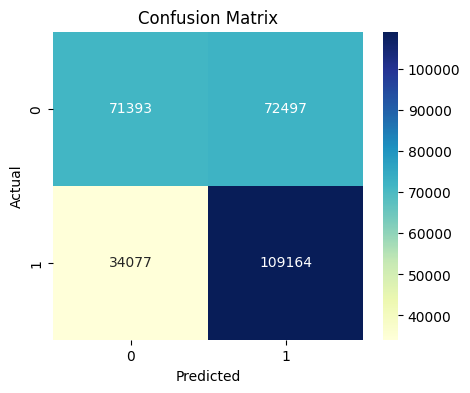

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Collect predictions and labels to driver
results = predictions.collect()
y_true = [x[0] for x in results]
y_pred = [x[1] for x in results]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Evaluate Models (AUC)

Evaluates the logistic regression and random forest models using the area under the ROC curve (AUC).

In [54]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np

# Predict on test set
lr_pred = lr_model.transform(test_df_balanced)
rf_pred = rf_model_balanced.transform(test_df_balanced)

# Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="is_high_severity", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc_lr = evaluator.evaluate(lr_pred)
auc_rf = evaluator.evaluate(rf_pred)
print(f"Logistic Regression AUC: {auc_lr:.3f}")
print(f"Random Forest AUC: {auc_rf:.3f}")

Logistic Regression AUC: 0.684
Random Forest AUC: 0.933


Logistic Regression Metrics:


              precision    recall  f1-score   support

           0      0.655     0.614     0.634    143890
           1      0.636     0.675     0.655    143241

    accuracy                          0.645    287131
   macro avg      0.645     0.645     0.645    287131
weighted avg      0.645     0.645     0.644    287131



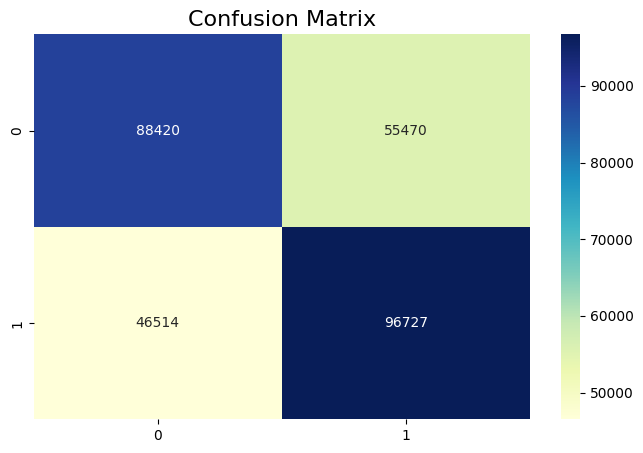

Confusion Matrix:
 [[88420 55470]
 [46514 96727]]
Random Forest Metrics:


              precision    recall  f1-score   support

           0      0.813     0.961     0.881    143890
           1      0.952     0.778     0.856    143241

    accuracy                          0.870    287131
   macro avg      0.882     0.869     0.868    287131
weighted avg      0.882     0.870     0.868    287131



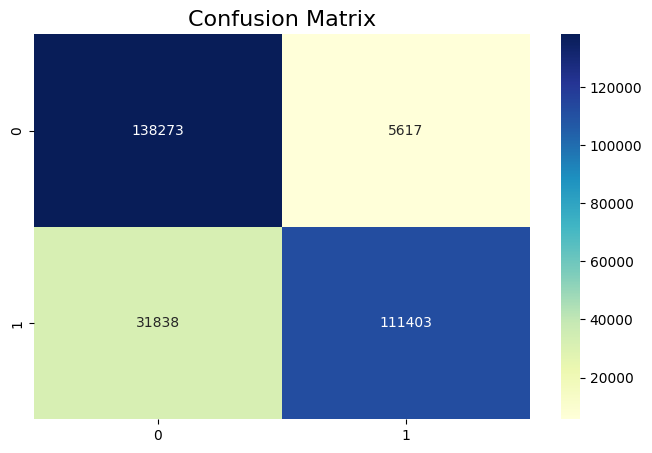

Confusion Matrix:
 [[138273   5617]
 [ 31838 111403]]


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
def get_metrics(pred_df):
    pred_pd = pred_df.select("is_high_severity", "prediction", "probability").toPandas()
    from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
    y_true = pred_pd["is_high_severity"]
    y_pred = pred_pd["prediction"]
    y_score = pred_pd["probability"].apply(lambda x: x[1])
    print(classification_report(y_true, y_pred, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (8,5))
    sns.heatmap(cm, annot=True,fmt='d',cmap="YlGnBu").set_title(
        "Confusion Matrix", fontsize=16)
    plt.show()
    print("Confusion Matrix:\n", cm)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return fpr, tpr, auc(fpr, tpr)

print("Logistic Regression Metrics:")
fpr_lr, tpr_lr, auc_lr_skl = get_metrics(lr_pred)
print("Random Forest Metrics:")
fpr_rf, tpr_rf, auc_rf_skl = get_metrics(rf_pred)

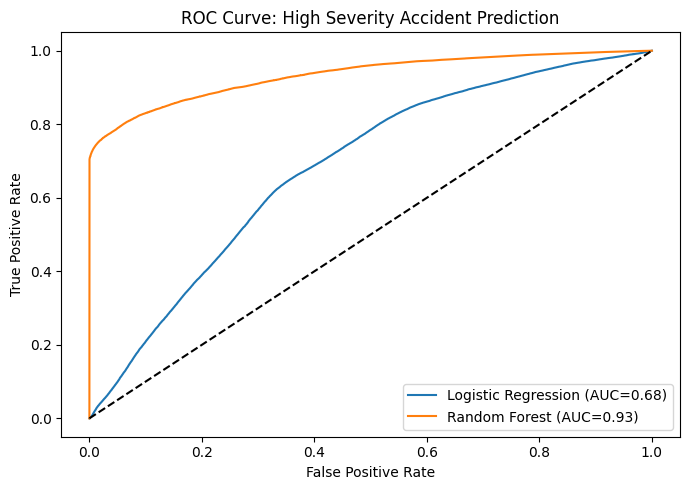

In [56]:

plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={auc_lr_skl:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf_skl:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: High Severity Accident Prediction")
plt.legend()
plt.tight_layout()
plt.show()

## Plot Feature Importances

Plots the top feature importances from the trained model.

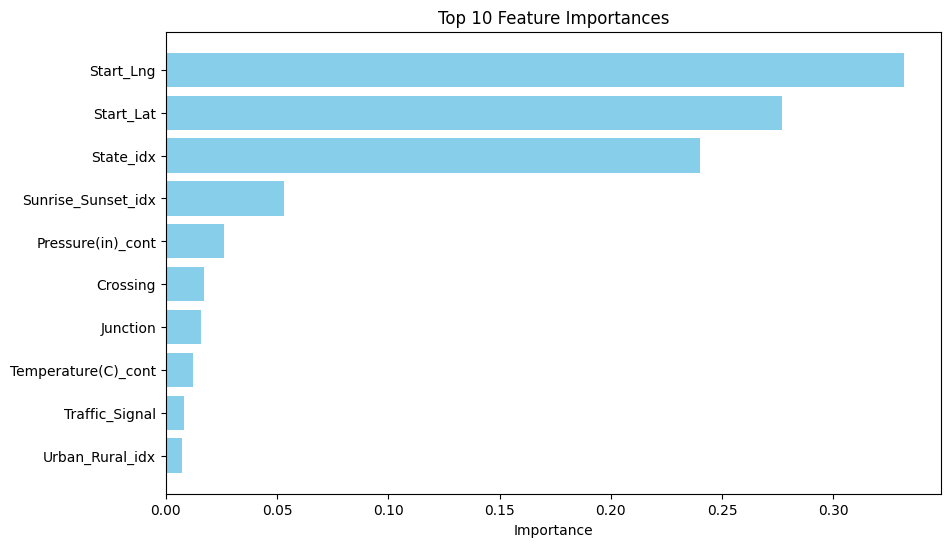

In [57]:
import matplotlib.pyplot as plt

top_n = 10  
top_feats = feat_imp.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_feats["feature"], top_feats["importance"], color="skyblue")
plt.gca().invert_yaxis()  # Highest importance at top
plt.xlabel("Importance")
plt.title(f"Top {top_n} Feature Importances")
plt.show()
